### Imports

In [1]:
import fsspec
import glob
import s3fs
import hvplot.pandas
import hvplot.xarray
import xarray as xr
import pandas as pd
import panel as pn
import holoviews as hv
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Markdown as md
from hip.analysis.analyses.drought import concat_obs_levels

pn.extension()
pn.extension("tabulator")

###  Reading functions

In [2]:
def read_aggregated_probs(path_to_zarr, index):
    fs, _, _ = fsspec.get_fs_token_paths(path_to_zarr)
    list_issue_paths = sorted(fs.glob(f"{path_to_zarr}/*"))[
        :-1
    ]  # Last one is the `obs` folder.
    list_index = {}

    for iss_path in list_issue_paths:
        list_index_paths = fs.glob(f"{iss_path}/{index} *")
        list_index_raw = [
            fs.sep.join([i, "probabilities.zarr"]) for i in sorted(list_index_paths)
        ]
        list_index_bc = [
            fs.sep.join([i, "probabilities_bc.zarr"]) for i in sorted(list_index_paths)
        ]
        index_names = [i.split(fs.sep)[-1] for i in sorted(list_index_paths)]

        # Restore full S3 paths if needed
        if isinstance(fs, s3fs.core.S3FileSystem):
            list_index_raw = [
                f"s3://{fs._strip_protocol(path)}" for path in list_index_raw
            ]
            list_index_bc = [
                f"s3://{fs._strip_protocol(path)}" for path in list_index_bc
            ]

        index_raw = xr.open_mfdataset(
            list_index_raw,
            engine="zarr",
            preprocess=lambda ds: ds["mean"],
            combine="nested",
            concat_dim="index",
        )
        index_bc = xr.open_mfdataset(
            list_index_bc,
            engine="zarr",
            preprocess=lambda ds: ds["mean"],
            combine="nested",
            concat_dim="index",
        )

        ds_index = xr.Dataset({"raw": index_raw, "bc": index_bc})
        ds_index["index"] = index_names
        list_index[int(iss_path.split(fs.sep)[-1])] = ds_index

    return xr.concat(list_index.values(), dim=pd.Index(list_index.keys(), name="issue"))

In [3]:
def read_aggregated_obs(path_to_zarr, index, intensity_thresholds):
    fs, _, _ = fsspec.get_fs_token_paths(path_to_zarr)
    list_index_paths = fs.glob(f"{path_to_zarr}/{index} *")

    # Restore full S3 paths if needed
    if isinstance(fs, s3fs.core.S3FileSystem):
        list_index_paths = [
            f"s3://{fs._strip_protocol(path)}" for path in list_index_paths
        ]

    list_val_paths = [
        fs.sep.join([ind_path, "observations.zarr"]) for ind_path in list_index_paths
    ]

    obs_val = xr.open_mfdataset(
        list_val_paths,
        engine="zarr",
        preprocess=lambda ds: ds["mean"],
        combine="nested",
        concat_dim="index",
    )
    obs_bool = concat_obs_levels(obs_val, levels=intensity_thresholds)

    obs = xr.Dataset({"bool": obs_bool, "val": obs_val})

    # Reformat time and index coords
    obs["time"] = [pd.to_datetime(t).year for t in obs.time.values]
    obs["index"] = [val_path.split(fs.sep)[-1] for val_path in list_index_paths]
    return obs

###  Define country and data path

In [4]:
COUNTRY = "ZWE"

# Ideally we would move the aa folder that's in my bucket to a dedicated bucket like for LIA
DATA_PATH = f"/s3/scratch/amine.barkaoui/aa/data/{COUNTRY.lower()}"

### Read indicator analysis data

In [5]:
probs_spi = read_aggregated_probs(f"{DATA_PATH}/zarr/2022", "spi")
probs_dry = read_aggregated_probs(f"{DATA_PATH}/zarr/2022", "dryspell")

probs = xr.concat([probs_spi, probs_dry], 'index')

In [6]:
probs

<xarray.Dataset> Size: 26MB
Dimensions:   (issue: 10, index: 30, time: 41, category: 2, district: 65)
Coordinates:
  * category  (category) <U8 64B 'Moderate' 'Normal'
  * district  (district) <U22 6kB 'Beitbridge' 'Bikita' ... 'Zvishavane'
  * time      (time) int64 328B 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021
  * index     (index) <U12 1kB 'spi AM' 'spi AMJ' ... 'dryspell OND'
  * issue     (issue) int64 80B 1 2 5 6 7 8 9 10 11 12
Data variables:
    raw       (issue, index, time, category, district) float64 13MB dask.array<chunksize=(1, 1, 41, 2, 65), meta=np.ndarray>
    bc        (issue, index, time, category, district) float64 13MB dask.array<chunksize=(1, 1, 41, 2, 65), meta=np.ndarray>

In [7]:
intensity_thresholds = {'Moderate': -0.85, 'Normal': -0.44}

chirps_spi = read_aggregated_obs(f"{DATA_PATH}/zarr/2022/obs", "spi", intensity_thresholds)
chirps_dry = read_aggregated_obs(f"{DATA_PATH}/zarr/2022/obs", "dryspell", intensity_thresholds)

chirps_anomaly = xr.concat([chirps_spi, chirps_dry], 'index')

In [8]:
chirps_anomaly

<xarray.Dataset> Size: 807kB
Dimensions:   (category: 2, index: 30, district: 65, time: 41)
Coordinates:
  * district  (district) <U22 6kB 'Beitbridge' 'Bikita' ... 'Zvishavane'
  * time      (time) int64 328B 1981 1982 1983 1984 1985 ... 2018 2019 2020 2021
  * category  (category) object 16B 'Moderate' 'Normal'
  * index     (index) <U12 1kB 'spi AM' 'spi AMJ' ... 'dryspell OND'
Data variables:
    bool      (category, index, district, time) int8 160kB dask.array<chunksize=(1, 1, 65, 41), meta=np.ndarray>
    val       (index, district, time) float64 640kB dask.array<chunksize=(1, 65, 41), meta=np.ndarray>

In [9]:
roc = pd.concat([
    pd.read_csv(f"{DATA_PATH}/auc/fbf.districts.roc.spi.2022.csv"),
    pd.read_csv(f"{DATA_PATH}/auc/fbf.districts.roc.dryspell.2022.csv"),    
])

In [10]:
roc

,category,district,AUC_best,BC,Index,issue
0,Moderate,Bulawayo,0.593750,1,SPI ON,7
1,Moderate,Harare,0.467803,0,SPI ON,7
2,Moderate,Buhera,0.669464,0,SPI ON,7
3,Moderate,Chimanimani,0.687463,1,SPI ON,7
4,Moderate,Chipinge,0.691428,0,SPI ON,7
...,...,...,...,...,...,...
19495,Normal,Gweru,0.756887,0,DRYSPELL AMJ,2
19496,Normal,Kwekwe,0.564263,0,DRYSPELL AMJ,2
19497,Normal,Mberengwa,0.501897,0,DRYSPELL AMJ,2
19498,Normal,Shurugwi,0.642542,0,DRYSPELL AMJ,2


### Visualize indicator performance analysis

**This roc file shows 22.0 % of bias-corrected values.**

,category,district,AUC_best,BC,Index,issue
0,Moderate,Bulawayo,0.593750,1,SPI ON,7
1,Moderate,Harare,0.467803,0,SPI ON,7
2,Moderate,Buhera,0.669464,0,SPI ON,7
3,Moderate,Chimanimani,0.687463,1,SPI ON,7
4,Moderate,Chipinge,0.691428,0,SPI ON,7
...,...,...,...,...,...,...
19495,Normal,Gweru,0.756887,0,DRYSPELL AMJ,2
19496,Normal,Kwekwe,0.564263,0,DRYSPELL AMJ,2
19497,Normal,Mberengwa,0.501897,0,DRYSPELL AMJ,2
19498,Normal,Shurugwi,0.642542,0,DRYSPELL AMJ,2


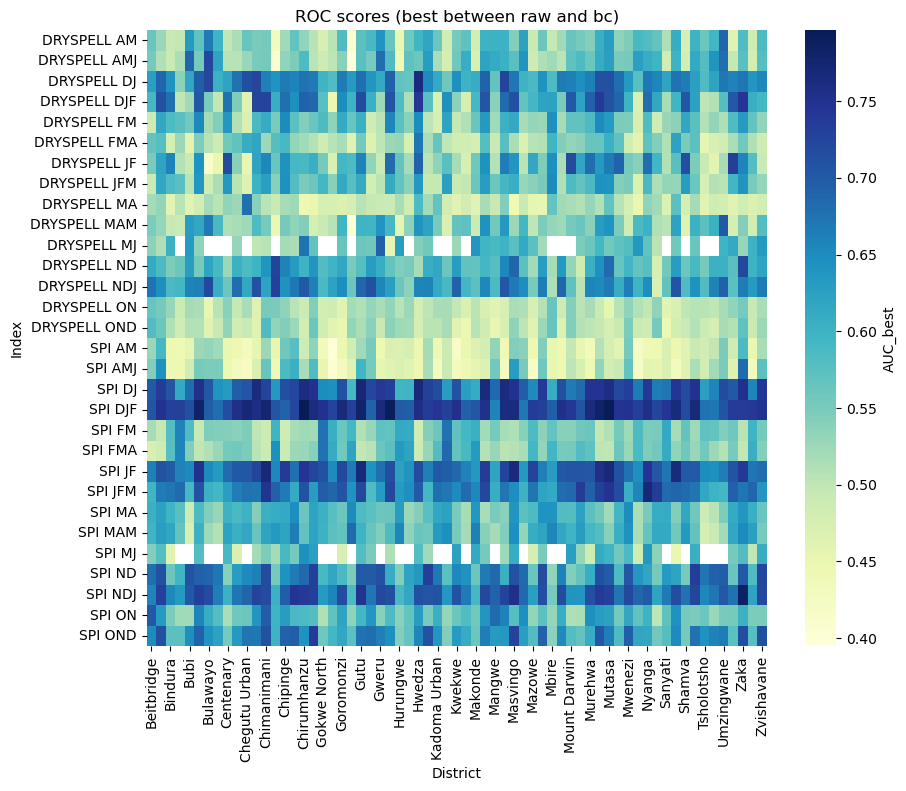

In [11]:
# ROC scores
display(
    md(
        f"**This roc file shows {round(100 * roc.BC.sum() / len(roc), 1)} % of bias-corrected values.**"
    )
)
display(roc)

# Filter to include only 'AUC_best' scores and pivot the table
roc_pivot = roc.pivot_table(values="AUC_best", index="Index", columns="district")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(roc_pivot, annot=False, cmap="YlGnBu", cbar_kws={"label": "AUC_best"})
plt.title("AUC_best Scores Heatmap - Below Normal")
plt.xlabel("District")
plt.ylabel("Index")
plt.title("ROC scores (best between raw and bc)")
plt.show()

In [12]:
# Probabilities
issue_widget = pn.widgets.Select(name="Issue Month", options=sorted(probs.issue.values.tolist()))
district_widget = pn.widgets.Select(name="District", options=sorted(probs.district.values.tolist()))
category_widget = pn.widgets.Select(name="Category", options=sorted(probs.category.values.tolist()))
index_widget = pn.widgets.Select(name="Index", options=sorted(probs.sel(issue=issue_widget.value).index.values.tolist()))
     
@pn.depends(issue_widget, index_widget, district_widget, category_widget)
def plot_timeseries(issue, index, district, category):
    sel = probs.sel(issue=issue, index=index, district=district, category=category)

    raw_plot = sel["raw"].hvplot(label="Raw", color="blue")
    bc_plot = sel["bc"].hvplot(label="Bias-Corrected", color="green")

    return (raw_plot * bc_plot).opts(show_grid=True, legend_position="top_left")

###
# Here please make sure to select an index within the 7-month leadtime of the issue month
###

pn.Column(
    pn.Row(issue_widget, index_widget),
    pn.Row(district_widget, category_widget),
    plot_timeseries
)

Column
    [0] Row
        [0] Select(name='Issue Month', options=[1, 2, 5, 6, 7, ...], value=1)
        [1] Select(name='Index', options=['dryspell AM', ...], value='dryspell AM')
    [1] Row
        [0] Select(name='District', options=['Beitbridge', ...], value='Beitbridge')
        [1] Select(name='Category', options=['Moderate', 'Normal'], value='Moderate')
    [2] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [22]:
# Observations
district_widget = pn.widgets.Select(name="District", options=sorted(probs.district.values.tolist()))
category_widget = pn.widgets.Select(name="Category", options=sorted(probs.category.values.tolist()))
index_widget = pn.widgets.Select(name="Index", options=sorted(probs.sel(issue=issue_widget.value).index.values.tolist()))
     
@pn.depends(index_widget, district_widget, category_widget)
def plot_obs_timeseries(index, district, category):
    sel = chirps_anomaly.sel(index=index, district=district, category=category)
    df = sel[["val", "bool"]].to_dataframe().reset_index()
    line = df.hvplot.line(x="time", y="val", color="blue", label="Anomaly")

    points_df = df[df["bool"] == 1]
    points = points_df.hvplot.scatter(
        x="time", y="val", color="red", size=10, marker="o", label="Anomaly < Threshold"
    )

    threshold = intensity_thresholds.get(category, None) * 1000
    if threshold is not None:
        hline = hv.HLine(threshold).opts(color="red", line_dash="dashed", line_width=2)
        return (line * points * hline).opts(show_grid=True, legend_position="top_left")

    return (line * points).opts(show_grid=True, legend_position="top_left")


pn.Column(
    pn.Row(index_widget, district_widget, category_widget),
    plot_obs_timeseries
)

Column
    [0] Row
        [0] Select(name='Index', options=['dryspell AM', ...], value='dryspell AM')
        [1] Select(name='District', options=['Beitbridge', ...], value='Beitbridge')
        [2] Select(name='Category', options=['Moderate', 'Normal'], value='Moderate')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

###  Read triggers data

In [72]:
triggers = pd.concat([
    *[pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/triggers/triggers_metrics_dry/*")],
    *[pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/triggers/triggers_metrics_spi2/*")],
    *[pd.read_csv(f) for f in glob.glob(f"{DATA_PATH}/triggers/triggers_metrics_spi3/*")],
])

In [82]:
triggers

,ready,set,index,district,category,issue_ready,lead_time,issue_set,FAR,FN,FP,FR,HR,RP,SR,TN,TP
0,0.00,0.00,dryspell DJ,Beitbridge,Moderate,7,12,8,0.829268,0.0,34.0,0.560976,1.000,1.0,0.439024,0.0,7.0
1,0.00,0.00,dryspell DJ,Beitbridge,Moderate,8,12,9,0.829268,0.0,34.0,0.560976,1.000,1.0,0.439024,0.0,7.0
2,0.00,0.00,dryspell DJ,Beitbridge,Moderate,9,12,10,0.829268,0.0,34.0,0.560976,1.000,1.0,0.439024,0.0,7.0
3,0.00,0.00,dryspell DJ,Beitbridge,Moderate,10,12,11,0.829268,0.0,34.0,0.560976,1.000,1.0,0.439024,0.0,7.0
4,0.00,0.00,dryspell DJ,Beitbridge,Moderate,11,12,12,0.829268,0.0,34.0,0.560976,1.000,1.0,0.439024,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142039,0.94,0.67,spi NDJ,Mwenezi,Normal,9,11,10,0.000000,11.0,0.0,0.000000,0.083,41.0,0.999999,29.0,1.0
142040,0.94,0.68,spi NDJ,Mwenezi,Normal,9,11,10,0.000000,11.0,0.0,0.000000,0.083,41.0,0.999999,29.0,1.0
142041,0.94,0.69,spi NDJ,Mwenezi,Normal,9,11,10,0.000000,11.0,0.0,0.000000,0.083,41.0,0.999999,29.0,1.0
142042,0.94,0.70,spi NDJ,Mwenezi,Normal,9,11,10,0.000000,11.0,0.0,0.000000,0.083,41.0,0.999999,29.0,1.0


### Visualize trigger metrics

In [80]:
index_options = sorted(triggers["index"].unique())
district_options = sorted(triggers["district"].unique())
category_options = sorted(triggers["category"].unique())

index_widget = pn.widgets.Select(name="Index", options=index_options)
district_widget = pn.widgets.Select(name="District", options=district_options)
category_widget = pn.widgets.Select(name="Category", options=category_options)

@pn.depends(
    index_widget, district_widget, category_widget,
)
def filtered_table(index, district, category):
    filtered = triggers[
        (triggers["index"] == index) &
        (triggers["district"] == district) &
        (triggers["category"] == category)
    ]
    return pn.widgets.Tabulator(filtered, pagination="local", page_size=10, width=1000)

pn.Column(
    pn.Row(index_widget, district_widget, category_widget),
    filtered_table
)

Column
    [0] Row
        [0] Select(name='Index', options=['dryspell DJ', ...], value='dryspell DJ')
        [1] Select(name='District', options=['Beitbridge', ...], value='Beitbridge')
        [2] Select(name='Category', options=['Moderate', 'Normal'], value='Moderate')
    [1] ParamFunction(function, _pane=Tabulator, defer_load=False)